# Netflix: Recomendador basado en contenido

El objetivo de este notebook es construir un modelo lineal que permita predecir la valoración (rating) que un usuario otorga a una película, en función de los atributos de dicha película. Para ello, se definirán las variables independientes como las características específicas de las películas (por ejemplo, género, duración, año de estreno, etc.), mientras que la variable dependiente será el rating proporcionado por el usuario. A continuación, se estimarán los coeficientes del modelo, que reflejan la importancia relativa de cada atributo en la valoración final. Esta estimación se podrá realizar de forma individualizada para cada usuario o bien para grupos de usuarios con preferencias similares. Finalmente, el modelo será validado mediante un conjunto de datos independiente, con el fin de evaluar su capacidad predictiva y generalización.

Primero vamos a importar los datos obtenidos desde el enlace proporcionado en el enunciado de la práctica.

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Carga de datos

ruta_base = '/Users/richard/Desktop/BigData-USC/ACUE/Practica/Practica final/ml-10M100K/'
# Cargar movies.dat
movies = pd.read_csv(ruta_base + 'movies.dat', 
                     sep='::', 
                     engine='python', 
                     header=None, 
                     names=['MovieID', 'Title', 'Genres'])

# Cargar ratings.dat
ratings = pd.read_csv(ruta_base + 'ratings.dat', 
                      sep='::', 
                      engine='python', 
                      header=None, 
                      names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

# Mostrar las primeras filas
print("Películas:")
print(movies.head())

print("\nRatings:")
print(ratings.head())



Películas:
   MovieID                               Title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        Genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings:
   UserID  MovieID  Rating  Timestamp
0       1      122     5.0  838985046
1       1      185     5.0  838983525
2       1      231     5.0  838983392
3       1      292     5.0  838983421
4       1      316     5.0  838983392


Una vez hemos importado los datos de las peliculas y las valoraciones vamos a separar la columna de 'genres' para obtener una columna para cada una de los generos que hay y los codificaremos mediante 'one hot encoding' de tal forma que pondremos un 1 si la pelicula pertenece a ese genero y un 0, en caso contrario.

In [3]:
# One-hot encoding de los géneros
genre_dummies = movies['Genres'].str.get_dummies(sep='|')

# Unimos los géneros procesados con MovieID
movies = pd.concat([movies[['MovieID', 'Title']], genre_dummies], axis=1)

# Mostrar las primeras filas
print(movies.head())

   MovieID                               Title  (no genres listed)  Action  \
0        1                    Toy Story (1995)                   0       0   
1        2                      Jumanji (1995)                   0       0   
2        3             Grumpier Old Men (1995)                   0       0   
3        4            Waiting to Exhale (1995)                   0       0   
4        5  Father of the Bride Part II (1995)                   0       0   

   Adventure  Animation  Children  Comedy  Crime  Documentary  ...  Film-Noir  \
0          1          1         1       1      0            0  ...          0   
1          1          0         1       0      0            0  ...          0   
2          0          0         0       1      0            0  ...          0   
3          0          0         0       1      0            0  ...          0   
4          0          0         0       1      0            0  ...          0   

   Horror  IMAX  Musical  Mystery  Romance  

Para obtener finalmente nuestro dataset completo con el que vamos a entrenar los modelos, uniremos el dataframe de peliculas con los generos separados y el dataframe de valoraciónes (rating)

In [5]:
data = pd.merge(ratings, movies, on='MovieID')

# Mostramos las primeras filas
print(data.head())

   UserID  MovieID  Rating  Timestamp                 Title  \
0       1      122     5.0  838985046      Boomerang (1992)   
1       1      185     5.0  838983525       Net, The (1995)   
2       1      231     5.0  838983392  Dumb & Dumber (1994)   
3       1      292     5.0  838983421       Outbreak (1995)   
4       1      316     5.0  838983392       Stargate (1994)   

   (no genres listed)  Action  Adventure  Animation  Children  ...  Film-Noir  \
0                   0       0          0          0         0  ...          0   
1                   0       1          0          0         0  ...          0   
2                   0       0          0          0         0  ...          0   
3                   0       1          0          0         0  ...          0   
4                   0       1          1          0         0  ...          0   

   Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
0       0     0        0        0        1       0       

Ahora que tenemos nuestro dataset completado podemos entrenar nuestro modelo.

En este caso vamos a seleccionar un usuario aleatorio, por ejemplo el 1, filtraremos en nuestro dataset a las peliculas valoradas por este usuario.

Cuando hayamos obtenido los datos filtrados, los separaremos en train (80%) y test (20%), entrenaremos un modelo lineal, en este caso hemos decidido utilizar un modelo de SVM lineal, y para terminar, utilizaremos este modelo entrenado para hacer predicciones sobre las valoraciones de las peliculas de los datos de test del usuario.

In [7]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Elegimos un usuario
user_id = 59269

# Filtramos los datos del usuario
user_data = data[data['UserID'] == user_id]

# Seleccionamos las características (géneros)
X = user_data.drop(columns=['UserID', 'MovieID', 'Rating', 'Timestamp', 'Title', '(no genres listed)'])
y = user_data['Rating']

# Dividimos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo
model = LinearSVR(C=1.0, epsilon=0.1, random_state=42, max_iter=10000)
model.fit(X_train, y_train)

# Predecimos y evaluamos
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f'RMSE para el usuario {user_id}: {rmse:.3f}')
print('\nImportancia de los géneros para el usuario:')
for genre, coef in zip(X.columns, model.coef_):
    print(f'{genre}: {coef:.3f}')

RMSE para el usuario 59269: 0.613

Importancia de los géneros para el usuario:
Action: 0.000
Adventure: 0.000
Animation: 0.000
Children: -0.000
Comedy: 0.000
Crime: 0.000
Documentary: 0.300
Drama: 0.300
Fantasy: -0.000
Film-Noir: 0.500
Horror: -0.200
IMAX: 0.000
Musical: 0.000
Mystery: -0.000
Romance: 0.000
Sci-Fi: -0.000
Thriller: 0.000
War: 0.200
Western: 0.000


Para poder escoger algun usuario que nos pueda devolver valores mas visuales, podemos coger un usuario que tenga bastantes valoraciones y con el que el modeloo aprendera mucho más. Por lo que nos dara unos coeficientes más representativos.

In [9]:
# Contar cuántas películas ha calificado cada usuario
user_counts = data['UserID'].value_counts()
print(user_counts.head(10))

UserID
59269    7359
67385    7047
14463    5169
68259    4483
27468    4449
3817     4165
19635    4165
63134    3755
58357    3697
27584    3479
Name: count, dtype: int64


Ahora que sabemos que nos funciona el modelo con usuarios particulares, pasamos a agrupar en grupos de usuarios.

Para ello vamos a realizar un clustering y probaremos con diversos numeros de grupos (clusters) y nos quedaremos con la mejor opcion de los que hemos probado.

In [21]:
# Seleccionamos solo las columnas necesarias
genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
              'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# Agrupar: promedio de rating por género por usuario
user_profiles = data.groupby('UserID')[genre_cols + ['Rating']].mean()
print(user_profiles.head())

from sklearn.cluster import KMeans

# Quitamos la columna 'Rating' para agrupar solo por preferencias de género
X_cluster = user_profiles.drop(columns=['Rating'])

# Entrenamos el modelo de clustering 
kmeans = KMeans(n_clusters=20, random_state=42)
clusters = kmeans.fit_predict(X_cluster)

# Añadimos el cluster al perfil de usuario
user_profiles['Cluster'] = clusters
print(user_profiles[['Rating', 'Cluster']].head())

          Action  Adventure  Animation  Children    Comedy     Crime  \
UserID                                                                 
1       0.454545   0.272727   0.181818  0.318182  0.500000  0.090909   
2       0.700000   0.500000   0.000000  0.050000  0.200000  0.050000   
3       0.212121   0.181818   0.060606  0.060606  0.333333  0.090909   
4       0.447368   0.342105   0.078947  0.131579  0.500000  0.131579   
5       0.057471   0.091954   0.011494  0.045977  0.333333  0.126437   

        Documentary     Drama   Fantasy  Film-Noir    Horror  IMAX   Musical  \
UserID                                                                         
1               0.0  0.272727  0.090909   0.000000  0.000000   0.0  0.136364   
2               0.0  0.350000  0.050000   0.000000  0.050000   0.0  0.050000   
3               0.0  0.606061  0.090909   0.030303  0.000000   0.0  0.030303   
4               0.0  0.368421  0.131579   0.000000  0.026316   0.0  0.078947   
5              

In [23]:
from sklearn.svm import LinearSVR

# Asociamos cada usuario con su cluster
user_cluster_map = user_profiles['Cluster'].to_dict()
data['Cluster'] = data['UserID'].map(user_cluster_map)


models = {}
rmses = {}
all_y_true = []
all_y_pred = []

for c in sorted(data['Cluster'].dropna().unique()):
    all_y_true.extend((y_val >= 4).astype(int))  # Valoración positiva si ≥ 4
    all_y_pred.extend(y_pred)
    group_data = data[data['Cluster'] == c]
    X = group_data[genre_cols]
    y = group_data['Rating']
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entrenar modelo SVM lineal
    model = LinearSVR(C=1.0, epsilon=0.1, random_state=42, max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    #print(y_val,y_pred)

    models[c] = model
    rmses[c] = rmse

    print(f'\nCluster {c} — RMSE: {rmse:.3f}')
    print('Importancia de géneros (coeficientes SVM):')
    for genre, coef in zip(X.columns, model.coef_):
        print(f'{genre}: {coef:.3f}')


Cluster 0 — RMSE: 0.998
Importancia de géneros (coeficientes SVM):
Action: -0.197
Adventure: 0.089
Animation: 0.460
Children: -0.368
Comedy: -0.267
Crime: 0.207
Documentary: 0.236
Drama: 0.199
Fantasy: 0.016
Film-Noir: 0.191
Horror: -0.091
IMAX: 0.224
Musical: -0.145
Mystery: 0.015
Romance: 0.002
Sci-Fi: -0.098
Thriller: 0.029
War: 0.233
Western: -0.053

Cluster 1 — RMSE: 1.079
Importancia de géneros (coeficientes SVM):
Action: -0.179
Adventure: 0.179
Animation: 0.325
Children: -0.325
Comedy: 0.001
Crime: 0.182
Documentary: 0.499
Drama: 0.319
Fantasy: 0.153
Film-Noir: 0.319
Horror: -0.300
IMAX: 0.023
Musical: 0.182
Mystery: 0.181
Romance: 0.025
Sci-Fi: -0.019
Thriller: 0.000
War: 0.189
Western: -0.001

Cluster 2 — RMSE: 0.997
Importancia de géneros (coeficientes SVM):
Action: -0.200
Adventure: 0.000
Animation: 0.500
Children: -0.300
Comedy: -0.200
Crime: 0.200
Documentary: 0.300
Drama: 0.300
Fantasy: -0.000
Film-Noir: 0.299
Horror: -0.000
IMAX: 0.200
Musical: -0.000
Mystery: 0.001
Rom

#### Comentario de los resultados obtenidos en ambos modelos (usuarios individuales y grupos de usuarios)

En ambos casos hemos calculado un RMSE, que nos indica la variación que tienen nuestras predicciones de los modelos generados con el valor real de las valoraciones que hacen los  usuarios, ya sea de manera individual como colectiva. Para entender este valor, es necesario explicar que se calcula a partir de la media de diferencias entre las valoraciones predichas y reales como mencionabamos antes, por tanto su valor se encuentra en la misma escala que las valoraciones de 0 a 5, es por ello que si nos da un valor muy alto nos indicaria que normlamente falla, y que este modelo puede diferir en ese valor entre la valoración predicha y la real, es decir, cuanto mas bajo sea este valor, mejor sera el modelo generado.

En cuanto a los coeficientes calculados en cada uno de los modelos, resulta facil de comprender su significado. Para cada una de las caracteristicas (en este caso, generos de las peliculas) se obtiene un valor que puede ser positivo y negativo, dicho valor nos indicara el interes que tiene el usuario individual o el grupo de usuarios por el genero. De esta forma si tenemos un valor muy alto negativo nos indicara que el usuario o grupo de usuarios no tienen ningun interés en este genero en concreto, por el contrario, si su valor es muy alto y positivo nos indicara que estan muy interesados en este género en especifico. Con estos datos podemos saber entonces que gustos tienen los usuarios, y al saber los generos de las peliculas nos resultará sencillo averiguar si el usuario mostrará interés de forma positiva hacia ellas, ya qu econocemos sus gustos y preferencias, ya sea de forma individual o colectiva.


Para finalizar, como podemos observar en este Notebook, cuando generamos un modelo idividual para un usuario en especifico, su valor del RMSE tiende a ser mas bajo que cualquier modelo de agrupación de usuarios, esto se debe a que los individuos tienen gustos diferentes cada uno de ellos y resulta muy difícil encasillar varios usuarios en el mismo grupo de gustos y preferencias.

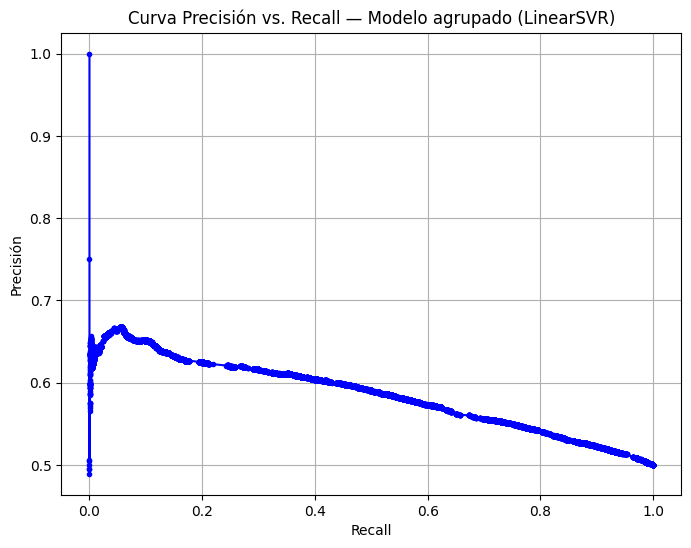

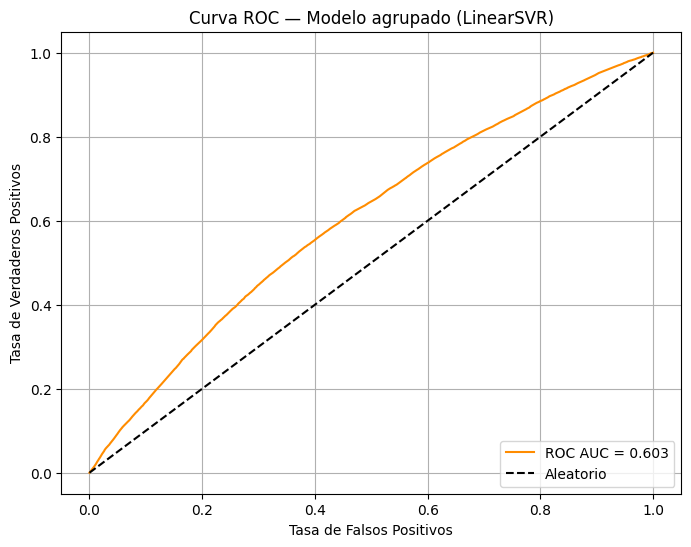

In [25]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Convertir acumulaciones previas en arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# === Curva Precisión vs. Recall ===
precision, recall, _ = precision_recall_curve(all_y_true, all_y_pred)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='blue')
plt.title('Curva Precisión vs. Recall — Modelo agrupado (LinearSVR)')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.grid(True)
plt.show()

# === Curva ROC ===
fpr, tpr, _ = roc_curve(all_y_true, all_y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.title('Curva ROC — Modelo agrupado (LinearSVR)')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Evaluación de recomendadores

Evaluando: Random Items
Evaluando: Popular Items
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluando: User-based CF
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Com

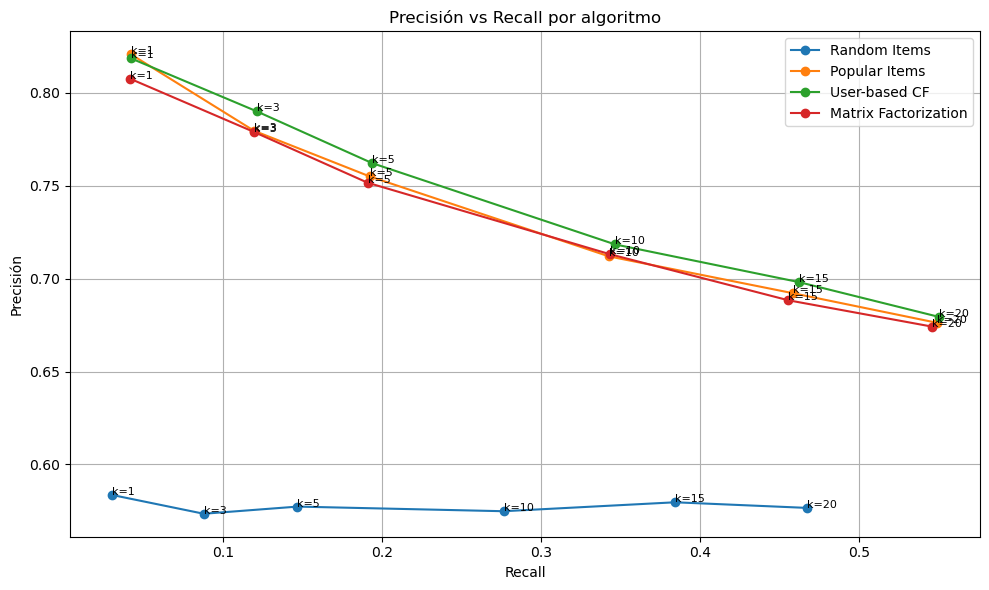

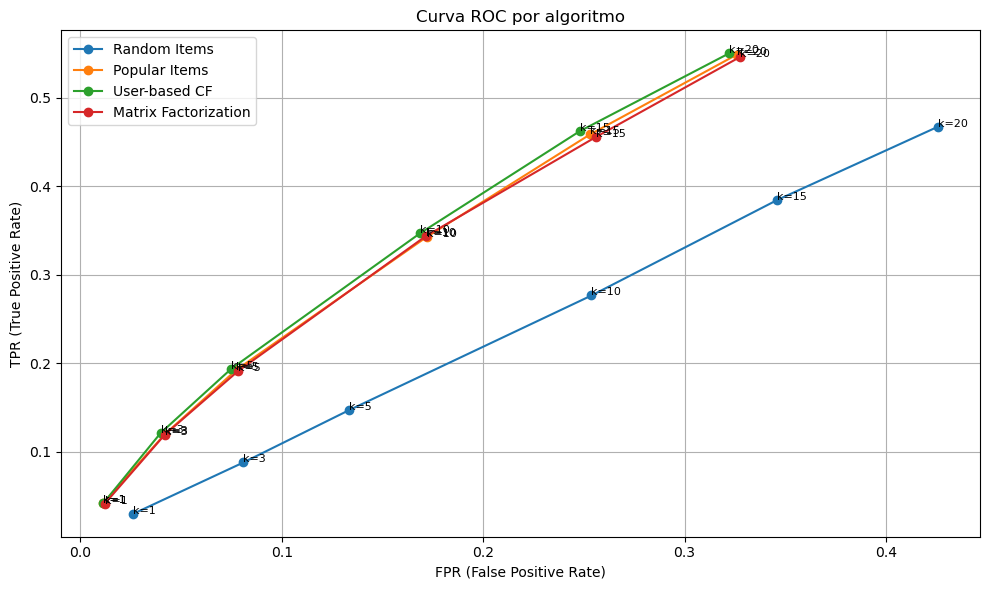

In [13]:
import pandas as pd
from surprise import Dataset, Reader
from surprise import SVD, KNNBasic, NormalPredictor, BaselineOnly
from surprise.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Cargamos el dataset MovieLens
data = Dataset.load_builtin('ml-100k')

# Define los algoritmos
algorithms = {
    "Random Items": NormalPredictor(),
    "Popular Items": BaselineOnly(),
    "User-based CF": KNNBasic(sim_options={'user_based': True}),
    "Matrix Factorization": SVD()
}

# Valores de k a evaluar
k_values = [1, 3, 5, 10, 15, 20]

# Diccionarios para almacenar métricas
precision_at_k = {name: [] for name in algorithms}
recall_at_k = {name: [] for name in algorithms}
tpr_at_k = {name: [] for name in algorithms}
fpr_at_k = {name: [] for name in algorithms}

# Calcular métricas
kf = KFold(n_splits=3)
threshold = 3.5


def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

def precision_recall_at_k(top_n, testset, k=10, threshold=3.5):
    hit_count = 0
    total_recommended = 0
    total_relevant = 0

    test_true = defaultdict(list)
    for uid, iid, true_r in testset:
        if true_r >= threshold:
            test_true[uid].append(iid)

    for uid, user_ratings in top_n.items():
        recommended_items = [iid for (iid, _) in user_ratings]
        relevant_items = test_true.get(uid, [])

        hits = len(set(recommended_items) & set(relevant_items))
        hit_count += hits
        total_recommended += len(recommended_items)
        total_relevant += len(relevant_items)

    precision = hit_count / total_recommended if total_recommended else 0
    recall = hit_count / total_relevant if total_relevant else 0

    return precision, recall


for name, algo in algorithms.items():
    print(f"Evaluando: {name}")
    for k in k_values:
        precisions = []
        recalls = []
        tprs = []
        fprs = []

        for trainset, testset in kf.split(data):
            algo.fit(trainset)
            predictions = algo.test(testset)
            top_n = get_top_n(predictions, n=k)

            prec, rec = precision_recall_at_k(top_n, testset, k=k, threshold=threshold)
            precisions.append(prec)
            recalls.append(rec)

            # Cálculo de TPR y FPR
            tp = fp = tn = fn = 0
            test_true = defaultdict(list)
            for uid, iid, true_r in testset:
                test_true[uid].append((iid, true_r))

            for uid, user_ratings in top_n.items():
                recommended = [iid for (iid, _) in user_ratings]
                true_items = test_true.get(uid, [])

                for iid, true_r in true_items:
                    if iid in recommended:
                        if true_r >= threshold:
                            tp += 1
                        else:
                            fp += 1
                    else:
                        if true_r >= threshold:
                            fn += 1
                        else:
                            tn += 1

            tpr = tp / (tp + fn + 1e-6)
            fpr = fp / (fp + tn + 1e-6)
            tprs.append(tpr)
            fprs.append(fpr)

        precision_at_k[name].append(np.mean(precisions))
        recall_at_k[name].append(np.mean(recalls))
        tpr_at_k[name].append(np.mean(tprs))
        fpr_at_k[name].append(np.mean(fprs))


from surprise import accuracy
from prettytable import PrettyTable

# Tabla de RMSE
rmse_table = PrettyTable()
rmse_table.field_names = ["Algoritmo", "RMSE promedio"]

for name, algo in algorithms.items():
    rmses = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)
        rmse = accuracy.rmse(predictions, verbose=False)
        rmses.append(rmse)
    rmse_table.add_row([name, round(np.mean(rmses), 4)])

print("\nResumen de RMSE por algoritmo:\n")
print(rmse_table)

# ---------- GRÁFICAS ---------- #

# 🎯 Precisión vs Recall
plt.figure(figsize=(10, 6))
for name in algorithms:
    plt.plot(recall_at_k[name], precision_at_k[name], marker='o', label=name)
    for i, k in enumerate(k_values):
        plt.annotate(f'k={k}', (recall_at_k[name][i], precision_at_k[name][i]), fontsize=8)
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Precisión vs Recall por algoritmo')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Guardar en formato PDF y PNG
plt.savefig('precision_vs_recall.pdf')
plt.savefig('precision_vs_recall.png')

# 📉 TPR vs FPR (ROC)
plt.figure(figsize=(10, 6))
for name in algorithms:
    plt.plot(fpr_at_k[name], tpr_at_k[name], marker='o', label=name)
    for i, k in enumerate(k_values):
        plt.annotate(f'k={k}', (fpr_at_k[name][i], tpr_at_k[name][i]), fontsize=8)
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('Curva ROC por algoritmo')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Guardar en formato PDF y PNG
plt.savefig('roc_curve.pdf')
plt.savefig('roc_curve.png')

plt.show()

# Creación de recomendador basado en factorización matricial

In [15]:
from surprise import SVD, NormalPredictor, BaselineOnly, KNNBasic
from surprise.model_selection import train_test_split
from surprise import Dataset, accuracy
import pickle

# Cargar el dataset de MovieLens
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=0.2)

# Definir el algoritmo de factorización matricial SVD
svd = SVD()

# Entrenar el modelo SVD
svd.fit(trainset)

# Guardar el modelo SVD
with open('svd_model.pkl', 'wb') as f:
    pickle.dump(svd, f)

# Hacer predicciones en el conjunto de prueba
predictions = svd.test(testset)

# Evaluar las predicciones
svd_rmse = accuracy.rmse(predictions)  # Error cuadrático medio para SVD

# Crear diccionario de los 5 mejores recomendadores
algorithms = {
    "Popular Items": BaselineOnly(),
    "User-based CF": KNNBasic(sim_options={'user_based': True}),
    "Item-based CF": KNNBasic(sim_options={'user_based': False}),
    "Matrix Factorization (SVD)": svd
}

# Inicializar variables para almacenar los RMSE de los otros modelos
popular_rmse = user_rmse_active = item_rmse = None

# Evaluar cada algoritmo
for name, algo in algorithms.items():
    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions)
    
    if name == "Popular Items":
        popular_rmse = rmse
    elif name == "User-based CF":
        user_rmse_active = rmse
    elif name == "Item-based CF":
        item_rmse = rmse
    elif name == "Matrix Factorization (SVD)":
        svd_rmse = rmse

RMSE: 0.9394
Estimating biases using als...
RMSE: 0.9458
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9796
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9744
RMSE: 0.9369


In [16]:
# Comparativa de resultados
print("Comparativa de RMSE:")
print(f"Modelo Popular:        {popular_rmse:.4f}")
print(f"User-Based CF:         {user_rmse_active:.4f}")
print(f"Item-Based CF:         {item_rmse:.4f}")
print(f"Factorización (SVD):   {svd_rmse:.4f}")


Comparativa de RMSE:
Modelo Popular:        0.9458
User-Based CF:         0.9796
Item-Based CF:         0.9744
Factorización (SVD):   0.9369


In [17]:
import random
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
import pickle
from surprise import accuracy

# Cargar el dataset de MovieLens
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=0.2)

# Cargar el modelo SVD previamente guardado
with open('svd_model.pkl', 'rb') as f:
    loaded_svd = pickle.load(f)

# Seleccionar una entrada aleatoria del conjunto de test
random_index = random.randint(0, len(testset) - 1)
uid, iid, true_r = testset[random_index]

# Realizar la predicción usando el modelo cargado
predicted = loaded_svd.predict(uid, iid)

# Mostrar los valores de entrada y los predichos
print(f"Entrada seleccionada (usuario {uid}, ítem {iid}):")
print(f"Valor real: {true_r}")
print(f"Valor predicho: {predicted.est:.4f}")


Entrada seleccionada (usuario 57, ítem 295):
Valor real: 5.0
Valor predicho: 3.2242
